In [1]:
# Import packages
import importlib
import os
import time
import numpy as np
import gc
import mosa
from paretoset import paretoset
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plots

In [2]:
# -------------- PART 0a: CHOOSE CIRCUIT AND SET UP FOLDER --------------                            #<--------- SAME AS CODE1 UP TO...

# Choose circuit
circuit = input("Please enter name of the circuit: ")

# Import circuit config file
config = importlib.import_module(circuit)

# Define subfolder name to work in
folder_name = f"MOSA_{circuit}"

# Create folder if not yet exist
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# Jump to folder
os.chdir(folder_name)

# Prompt new folder name
print(f"Current working directory: {os.getcwd()}")   

Current working directory: /Users/nt625/Documents/GitHub/My5thMOSArepository_plsdontcrash/TwoSpeciesCircuits/MOSA_posneg


In [3]:
# -------------- PART 0d: CHOOSE SENSITIVITY FUNCTIONS --------------

# Print prompt
print("""
We have the following sensitivity functions:
0. |S_betax_xss|
1. |S_betax_yss|
2. |S_betay_xss|
3. |S_betay_yss|
4. |S_n_xss|
5. |S_n_yss|
""")

# Choose pair of functions
choice1 = int(input("Please select first option number:"))
choice2 = int(input("Please select second option number:"))

# List of sensitivity function names
sensitivity_labels = [
    "|S_betax_xss|",
    "|S_betax_yss|",
    "|S_betay_xss|",
    "|S_betay_yss|",
    "|S_n_xss|",
    "|S_n_yss|"]

# Save function names for later use
label1 = sensitivity_labels[choice1]
label2 = sensitivity_labels[choice2]

# -------------- PART 0e: CHANGING DIRECTORIES --------------

# Define the subfolder name
subfolder_name = f"MOSA_sensfuncs_{choice1}_and_{choice2}/data"

# Jump to folder
os.chdir(subfolder_name)

# Prompt new folder name
print(f"Current working directory: {os.getcwd()}")


We have the following sensitivity functions:
0. |S_betax_xss|
1. |S_betax_yss|
2. |S_betay_xss|
3. |S_betay_yss|
4. |S_n_xss|
5. |S_n_yss|

Current working directory: /Users/nt625/Documents/GitHub/My5thMOSArepository_plsdontcrash/TwoSpeciesCircuits/MOSA_posneg/MOSA_sensfuncs_0_and_1/data


In [4]:
# -------------------- NEW STUFF --------------------

In [5]:
runs = int(input("How many MOSA runs did you run: "))
runs

10

In [6]:
# Loop through runs
for run in range(1, runs + 1):
    # Load the parameter values for that run's Pareto front
    pareto_sensfunc1 = np.load(f"pareto_sensfunc1_run{run}.npy", allow_pickle=True)
    pareto_sensfunc2 = np.load(f"pareto_sensfunc2_run{run}.npy", allow_pickle=True)

    # Stack the two arrays as columns
    pareto_front = np.column_stack((pareto_sensfunc1, pareto_sensfunc2))

    # There may be NaNs in the array. Pareto minimisation will think NaNs are minimum. We don't want this. Let's replace NaNs with infinities.
    pareto_front = np.where(np.isnan(pareto_front), np.inf, pareto_front)

    # Compute mask
    mask = paretoset(pareto_front, sense=["min", "min"])

    print(f"Run: {run}")
    if sum(mask) == len(pareto_sensfunc1):
        print("is good")

Run: 1
is good
Run: 2
is good
Run: 3
is good
Run: 4
is good
Run: 5
is good
Run: 6
is good
Run: 7
is good
Run: 8
is good
Run: 9
is good
Run: 10
is good


In [7]:
# Sequence to store Pareto front matrices (each matrix is n x 2)
pareto_front_sequence = []
# Sequence to store Pareto paremeter matrices (each matrix is n x 3)
pareto_param_sequence = []

# Loop through runs
for run in range(1, runs + 1):
    AllParetoFrontsUpToCurrentRun = np.empty((0, 2))  # Initialize an empty array
    AllParetoParamsUpToCurrentRun = np.empty((0, 3))  # Initialize an empty array

    # Accumulate data from the first run up to the current run
    for i in range(1, run + 1):

        pareto_sensfunc1 = np.load(f"pareto_sensfunc1_run{i}.npy", allow_pickle=True)
        pareto_sensfunc2 = np.load(f"pareto_sensfunc2_run{i}.npy", allow_pickle=True)

        CurrentParetoFront = np.column_stack((pareto_sensfunc1, pareto_sensfunc2))
        AllParetoFrontsUpToCurrentRun = np.vstack((AllParetoFrontsUpToCurrentRun, CurrentParetoFront))

        pareto_betax = np.load(f"pareto_betax_run{i}.npy", allow_pickle=True)
        pareto_betay = np.load(f"pareto_betay_run{i}.npy", allow_pickle=True)
        pareto_n     = np.load(f"pareto_n_run{i}.npy", allow_pickle=True)

        CurrentParetoParam = np.column_stack((pareto_betax, pareto_betay, pareto_n))
        AllParetoParamsUpToCurrentRun = np.vstack((AllParetoParamsUpToCurrentRun, CurrentParetoParam))

    # Compute Pareto-optimal points
    mask = paretoset(AllParetoFrontsUpToCurrentRun, sense=["min", "min"])
    filteredfront = AllParetoFrontsUpToCurrentRun[mask]
    filteredparam = AllParetoParamsUpToCurrentRun[mask]

    # Store the Pareto front and pareto parameters for this run in the sequence
    pareto_front_sequence.append(filteredfront)
    pareto_param_sequence.append(filteredparam)

# Convert to NumPy object array (variable-sized slices)
pareto_front_sequence = np.array(pareto_front_sequence, dtype=object)
pareto_param_sequence = np.array(pareto_param_sequence, dtype=object)

print("Shape of pareto_front_sequence:", np.shape(pareto_front_sequence))
print("Shape of pareto_param_sequence:", np.shape(pareto_param_sequence))

Shape of pareto_front_sequence: (10,)
Shape of pareto_param_sequence: (10,)


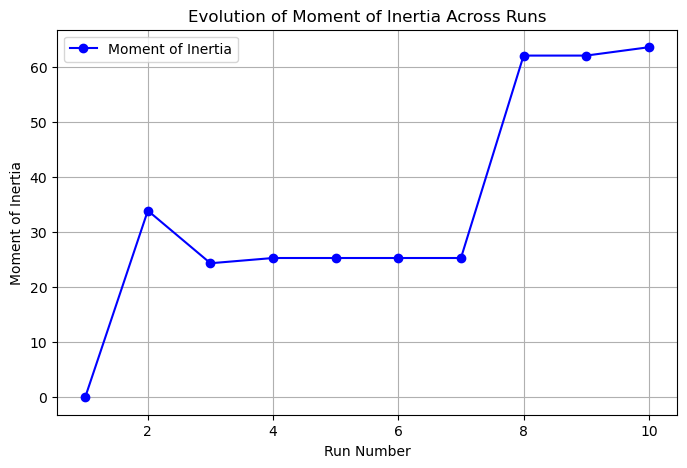

In [8]:
moments_of_inertia = []  # Store moment of inertia for each run

# Loop through runs
for run in range(runs):
    
    # Get the Pareto front for this run
    filteredfront = pareto_front_sequence[run]  # This is an (n, 2) matrix

    # Compute centroid
    centroid_x = np.mean(filteredfront[:, 0])
    centroid_y = np.mean(filteredfront[:, 1])

    # Compute moment of inertia (sum of squared distances from centroid)
    distances_sq = (filteredfront[:, 0] - centroid_x) ** 2 + (filteredfront[:, 1] - centroid_y) ** 2
    moment_of_inertia = np.sum(distances_sq)

    # Store moment of inertia
    moments_of_inertia.append(moment_of_inertia)

# Plot Moment of Inertia over Runs
plt.figure(figsize=(8, 5))
plt.plot(range(1, runs + 1), moments_of_inertia, marker="o", linestyle="-", color="blue", label="Moment of Inertia")
plt.xlabel("Run Number")
plt.ylabel("Moment of Inertia")
plt.title("Evolution of Moment of Inertia Across Runs")
plt.legend()
plt.grid()

# Save and show
plt.show()

/var/folders/00/1d6xmh4s561gn38h3vf1mlyh005mvp/T/ipykernel_83457/2060967768.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("tab10", len(selected_runs))  # Choose a colormap and get distinct colors


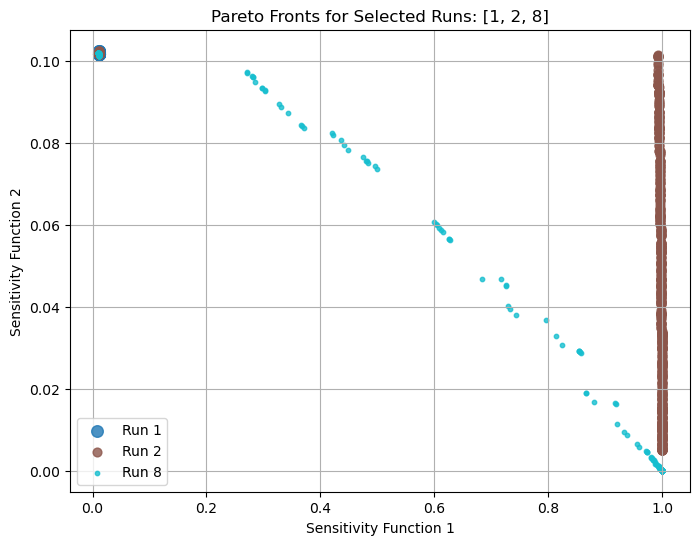

In [9]:
# Specify which runs you want to include
selected_runs = [1, 2, 8]  # Can be any number of runs

# Generate a unique color for each run using a colormap
cmap = cm.get_cmap("tab10", len(selected_runs))  # Choose a colormap and get distinct colors
color_map = {run: cmap(i) for i, run in enumerate(selected_runs)}

# Define marker size reduction (larger for earlier runs, smaller for later ones)
marker_sizes = {run: size for run, size in zip(selected_runs, np.linspace(70, 10, len(selected_runs)))}  # Adjust dynamically

plt.figure(figsize=(8, 6))

# Loop through only selected runs
for i, run in enumerate(selected_runs):
    # Retrieve the precomputed Pareto front for this run
    filteredfront = pareto_front_sequence[run - 1]  # Convert to 0-based index

    # Scatter plot for this specific run with adjusted marker size and color
    plt.scatter(filteredfront[:, 0], filteredfront[:, 1], 
                color=color_map[run], label=f"Run {run}", marker="o", s=marker_sizes[run], alpha=0.8)

# Labels and legend
plt.xlabel("Sensitivity Function 1")  # Adjust labels as needed
plt.ylabel("Sensitivity Function 2")
plt.title(f"Pareto Fronts for Selected Runs: {selected_runs}")
plt.legend()  # Uses discrete legend instead of colorbar
plt.grid()

# Save and show figure
plt.show()

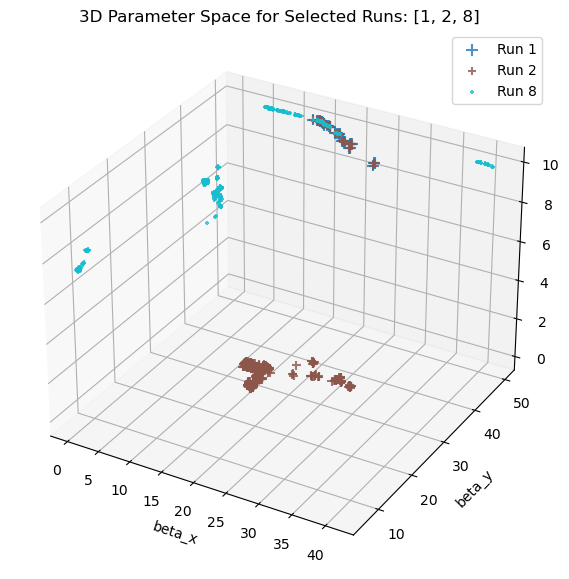

In [14]:
# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Loop through only selected runs
for run in selected_runs:
    # Retrieve the corresponding parameter set for this run
    parameter_values = pareto_param_sequence[run - 1]  # Convert to 0-based index

    # Scatter plot for the parameter values
    ax.scatter(parameter_values[:, 0], parameter_values[:, 1], parameter_values[:, 2], 
               color=color_map[run], label=f"Run {run}", marker="+", s=marker_sizes[run], alpha=0.8)

# Labels and legend
ax.set_xlabel("beta_x")
ax.set_ylabel("beta_y")
ax.set_zlabel("n")
ax.set_title(f"3D Parameter Space for Selected Runs: {selected_runs}")
ax.legend()
plt.grid()

# Save and show figure
plt.show()